# Inventures Technical Test

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
from geopy import distance
import numpy as np
from geopy.geocoders import Nominatim

# Load the data
filename = 'vehicle_gps.csv' 
df = pd.read_csv(filename)

The dataframe has shape: (77, 4)
  vehicle   latitude  longitude        timestamp
0       A -33.416709 -70.592693  01-01-2022 8:01
1       A -33.417425 -70.592487  01-01-2022 8:02
2       A -33.417831 -70.592367  01-01-2022 8:04
3       A -33.417879 -70.592018  01-01-2022 8:05
4       A -33.417818 -70.591653  01-01-2022 8:06


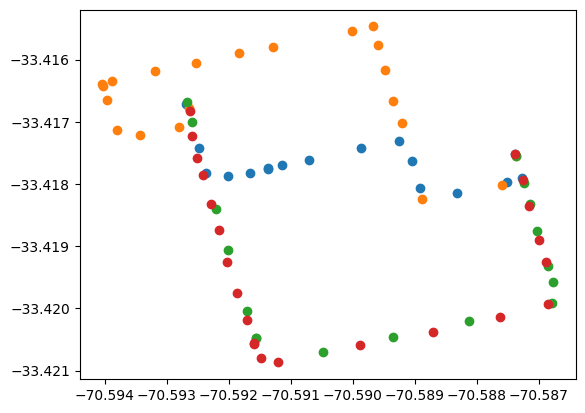

In [2]:
# Visualize data
print('The dataframe has shape: '+str( df.shape))
print(df.head())
df_list = []
for v in df['vehicle'].unique():
    adf = df[df['vehicle']==v]
    df_list.append(adf)
    plt.scatter(x=adf['longitude'], y=adf['latitude'])
plt.show()

In [3]:
# Some data cleaning
df = df.dropna() # drop all rows with NA values
df = df.drop_duplicates(subset=['vehicle','timestamp'], keep='first') # drop rows with duplicate vehicle and timestamp
# same time values for the same vehicle would mean the vehicle moved with infinite speed
print(f'The dataframe has shape: {df.shape}')

The dataframe has shape: (63, 4)


In [4]:
# Get day time by minutes
df['minutes'] = pd.to_datetime(df['timestamp']).dt.hour * 60 + pd.to_datetime(df['timestamp']).dt.minute 
df = df.reset_index()
df.head()
df_list = [] # List containing a dataframe for each vehicle
for v in df['vehicle'].unique():
    adf = df[df['vehicle']==v]
    df_list.append(adf.reset_index())

In [5]:

# Function to calculate the distance, time and speed of the vehicle (km/h) between locations
def get_speeds(df):
    speed_list = []
    for i, row in df.iterrows():
        if i == 0:
            bf_row = row
            speed = float("nan")
            speed_list.append(speed)
        else:
            lat1 = bf_row['latitude']
            lon1 = bf_row['longitude']
            lat2 = row['latitude']
            lon2 = row['longitude']
            p1 = (lat1, lon1)
            p2 = (lat2, lon2)
            bf_row = row

            # Calculate the distance between the two points
            dist = distance.distance(p1, p2).km
            
            # Get time difference in hours
            time = (df.iloc[i]['minutes'] - df.iloc[i-1]['minutes'])/60

            # Calculate speed in km/h
            speed = dist/time
            speed_list.append(speed)
            
        speed_series = pd.Series(speed_list, name='speed')
        speed_series.fillna(value=speed_series.mean(), inplace=True)
    return speed_series

# Function that generates a dictionary which contains node coordinates
# Made mostly for ease of use of the graph in the future
def get_node_dict(df):
    dict =  {}
    i = 0
    for _, row in df.iterrows():
        dict[i] = (row['latitude'], row['longitude'])
        i += 1
    return dict

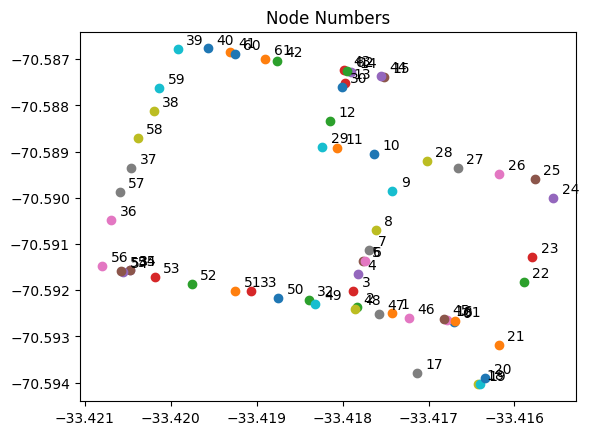

In [6]:
# Generate the node dictionary for ease of use of the graph
node_dict = get_node_dict(df)

# Create a new figure and axis object
fig, ax = plt.subplots()

# Define the offsets for the node number
dx, dy = 0.0001, 0.0001

# Iterate over the nodes in the graph
for node, coords in node_dict.items():
    # Plot the node as a circle
    ax.plot(coords[0], coords[1], 'o')
    
    # Add the node number as text with an offset
    ax.text(coords[0] + dx, coords[1] + dy, str(node))
    
# Show the plot
ax.set_title("Node Numbers")
plt.show()

In [7]:
speed_series_list = []
for adf in df_list:
    speed_series_list.append(get_speeds(adf))
speed_series = pd.concat(speed_series_list, ignore_index=True)
df = pd.concat((df, speed_series), axis=1)
print(df.head())
avg_speed = speed_series.mean()
print(f'The average speed between points travelled by all the vehicles is {avg_speed} km/hr')

   index vehicle   latitude  longitude        timestamp  minutes     speed
0      0       A -33.416709 -70.592693  01-01-2022 8:01      481  2.391507
1      1       A -33.417425 -70.592487  01-01-2022 8:02      482  4.901500
2      2       A -33.417831 -70.592367  01-01-2022 8:04      484  1.391785
3      3       A -33.417879 -70.592018  01-01-2022 8:05      485  1.973654
4      4       A -33.417818 -70.591653  01-01-2022 8:06      486  2.076980
The average speed between points travelled by all the vehicles is 3.3260791316903298 km/hr


There are multiples ways to generate a graph for vehicle travel with this data, such as:

1. One option would be to simply use each observation on the table as a node and connect them to one another depending on the distances between each other, then letting the weight of the connection be the time it takes to travel that distance, calculated by dividing the distance by a measure of speed, such as the mean speed of all the vehicles for example. This option doesn't take into consideration street restrictions.

2. It is also posible to modify the previous option and select different speeds depending of the street on which the vehicle is located. Using the measurements of latitude and longitude to obtain the real streets on which the vehicles are traveling.

3. Another option is to use the measurements of latitude and longitude to obtain the real streets on which the vehicles are traveling. Then use this knowledge to designate points of interest such as street intersections, initial and final vehicle position, as the nodes in the graph. Then connect the nodes to one another depending on the street restrictions and layout. Calculate the weight of the connections(travel time) with the distance between the selected nodes, divided by the mean speed of vehicles while on the street that connects the nodes.

We will explore the options 1 and 2, since option 3 would require paid APIs.

## Graph 1

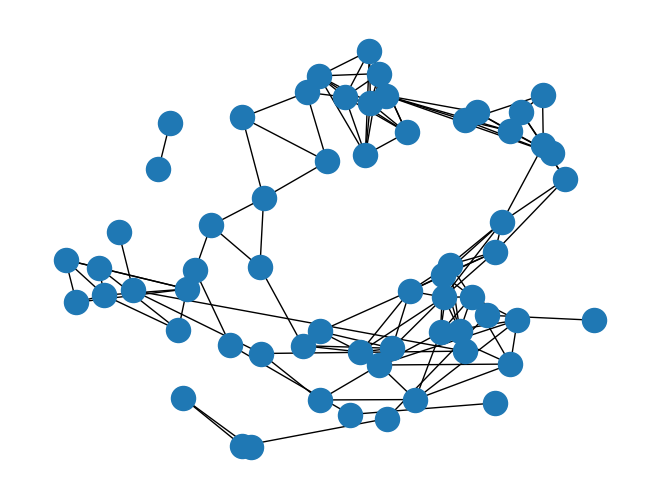

In [8]:
# Create an empty graph
G1 = nx.Graph()

# Add nodes to the graph
for i, row in df.iterrows():
    G1.add_node((row['latitude'], row['longitude']))

# Calculate travel time between two points
def calculate_travel_time(p1, p2, speed=50):
    dist = distance.distance(p1, p2).km
    time = dist / speed
    return time

# Calculate the minimun distance value so that each node has at least one connection
def calculate_minimum_distance(G):
    min_dist_list = []
    for u in G.nodes():
        min_dist = float('inf')
        for v in G.nodes():
            if u != v:
                dist = distance.distance(u, v).km
                min_dist = min(min_dist, dist)
        min_dist_list.append(min_dist)
    return max(min_dist_list)

min_dist = calculate_minimum_distance(G1)
#print(min_dist)

# Add edges to the graph
for u in G1.nodes():
    for v in G1.nodes():
        if u != v:
            dist = distance.distance(u, v).km
            if dist <= min_dist:
                travel_time = calculate_travel_time(u, v, avg_speed)
                G1.add_edge(u, v, weight=travel_time)

# Calculate shortest path and travel time between two nodes
def calculate_shortest_path(G, origin, destination):
    try:
        path = nx.dijkstra_path(G, origin, destination, weight='weight')
        time = nx.dijkstra_path_length(G, origin, destination, weight='weight')
        return path, time
    except nx.NetworkXNoPath:
        return [], float('inf')
    
# Draw the graph
pos = nx.spring_layout(G1)
nx.draw(G1, pos, with_labels=False)

# Show the graph
plt.show()


In [9]:
# Example usage:
origin = node_dict[5]
destination = node_dict[50]
path, time = calculate_shortest_path(G1, origin, destination)
print(f'Shortest path: {path}')
print(f'Travel time: {time} hours')

Shortest path: [(-33.417763, -70.591365), (-33.417818, -70.591653), (-33.418316, -70.592294), (-33.418746, -70.592165)]
Travel time: 0.04748049293737126 hours


## Graph 2

In [10]:
def gps_plot(df): # Plot gps coordinates on a street map
    color_scale = [(0, 'yellow'), (1,'red')]
    fig = px.scatter_mapbox(df, 
                            lat='latitude', 
                            lon='longitude', 
                            hover_name='vehicle', 
                            hover_data=['vehicle', 'minutes'],
                            color='minutes',
                            color_continuous_scale=color_scale,
                            size='minutes',
                            zoom=16, 
                            height=800,
                            width=800)

    fig.update_layout(mapbox_style='open-street-map')
    fig.update_layout(margin={'r':0,'t':0,'l':0,'b':0})
    fig.show()

# Visualize all the vehicles path on a street map
gps_plot(df)
#for adf in df_list:
#    gps_plot(adf)

In [11]:
# Use a geocoding library to convert latitude and longitude coordinates into street addresses
geolocator = Nominatim(user_agent='myapplication')

def get_street(latitude, longitude):
    location = geolocator.reverse(f'{latitude}, {longitude}')
    return (location.raw['address'])['road']

df['street'] = df.apply(lambda row: get_street(row['latitude'], row['longitude']), axis=1)


In [12]:
print(df.head(5))

   index vehicle   latitude  longitude        timestamp  minutes     speed   
0      0       A -33.416709 -70.592693  01-01-2022 8:01      481  2.391507  \
1      1       A -33.417425 -70.592487  01-01-2022 8:02      482  4.901500   
2      2       A -33.417831 -70.592367  01-01-2022 8:04      484  1.391785   
3      3       A -33.417879 -70.592018  01-01-2022 8:05      485  1.973654   
4      4       A -33.417818 -70.591653  01-01-2022 8:06      486  2.076980   

    street  
0  Hendaya  
1  Hendaya  
2  Hendaya  
3   Callao  
4   Callao  


In [13]:
def gen_street_speed_dict(df):
    street_speed_dict = {}
    for s in df['street'].unique():
        street_speed_dict[s] = float(np.mean(df[df['street']==s]['speed']))
    return street_speed_dict
street_speed_dict = gen_street_speed_dict(df)

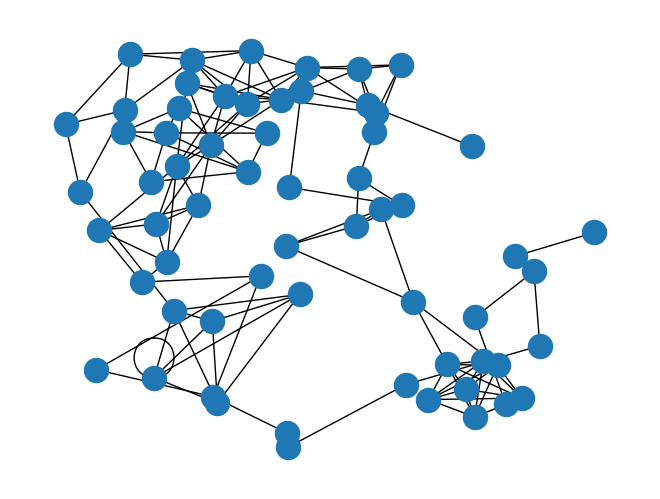

In [14]:
# Create a graph using Networkx
G2 = nx.Graph()

# Add nodes to the graph
for index, row in df.iterrows():
    G2.add_node((row['latitude'], row['longitude']))

# Add edges to the graph
for index, row in df.iterrows():
    for j, r in df.iterrows():
        if index != j:
            dist = distance.distance((row['latitude'], row['longitude']), (r['latitude'], r['longitude'])).km
            if dist <= min_dist:
                travel_time = dist/street_speed_dict[row['street']]
                G2.add_edge((row['latitude'], row['longitude']), (r['latitude'], r['longitude']), weight=travel_time)

#Visualize the graph
nx.draw(G2, with_labels=False)
plt.show()


In [15]:
# Example usage:
origin = node_dict[5]
destination = node_dict[50]
path, time = calculate_shortest_path(G2, origin, destination)
print(f'Shortest path: {path}')
print(f'Travel time: {time} hours')

Shortest path: [(-33.417763, -70.591365), (-33.417818, -70.591653), (-33.418316, -70.592294), (-33.418746, -70.592165)]
Travel time: 0.05290608983251871 hours


In [16]:
def show_path_map(coordinates):
    # Create a Pandas DataFrame with the coordinates
    df = pd.DataFrame(coordinates, columns=['latitude', 'longitude'])
    df['dummy_column_for_size'] = 1.
    df.reset_index(inplace=True)
    # Use scatter_mapbox to plot the coordinates
    color_scale = [(0, 'yellow'), (1,'red')]
    fig = px.scatter_mapbox(df, 
                            lat='latitude', 
                            lon='longitude', 
                            hover_name='index', 
                            color='index',
                            color_continuous_scale=color_scale,
                            size='dummy_column_for_size',
                            size_max=15,
                            zoom=17, 
                            height=800,
                            width=800)

    fig.update_layout(mapbox_style='open-street-map')
    fig.update_layout(margin={'r':0,'t':0,'l':0,'b':0})
    fig.show()
    return

show_path_map(path)